In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
data = pd.read_csv('/home/ibrahim/Desktop/covid-19/time_series_covid_19_confirmed.csv')
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


### US

In [676]:
nums = data[data['Country/Region']=='US'].sum().drop(['Province/State','Country/Region','Lat','Long'])
#nums = data[data['Country/Region']=='US'].sum().drop(['Lat','Long'])

In [677]:
y = data[data['Country/Region']=='US'].sum().drop(['Province/State','Country/Region','Lat','Long']).tolist()
x = range(len(y))

### All Countries

In [4]:
nums = data[:].sum().drop(['Lat','Long'])
#nums = data[data['Country/Region']=='US'].sum().drop(['Lat','Long'])

y = data[:].sum().drop(['Lat','Long']).tolist()
x = range(len(y))

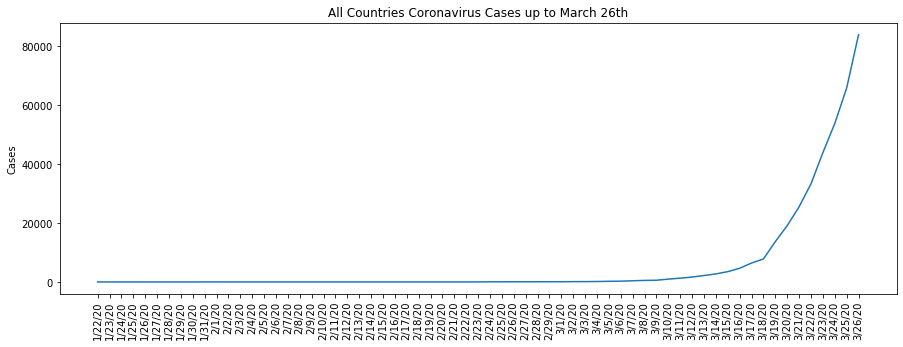

In [654]:
import matplotlib.pyplot as plt
import seaborn as sns
figure(figsize=(15,5))
plt.plot(nums)
plt.xticks(rotation=90)
plt.ylabel('Cases')
plt.title("All Countries Coronavirus Cases up to March 26th")
plt.show()

# InfectionRateNet 

In [668]:
import torch
from torch import nn
import numpy as np
import copy
from pylab import *
from torch.autograd import Variable


In [745]:

features = np.expand_dims(np.arange(65), 1) + 1
features = features.astype(np.float)

y = data[:].sum().drop(['Lat','Long']).tolist()

targets = np.expand_dims(np.array(y), 1)
targets = targets.astype(np.float)

fstd = np.std(features.flatten())
fmean = np.mean(features.flatten())


x = Variable(torch.from_numpy(features))
x = x.type(torch.FloatTensor)

y = Variable(torch.from_numpy(targets))
y = y.type(torch.FloatTensor)

y = torch.log(y)

tstd = torch.std(y)
tmean = torch.mean(y)

# x = (x - fmean) / fstd
# y = (y - tmean) / tstd

class InfectionRateNet(torch.nn.Module):
    def __init__(self):
        super(InfectionRateNet, self).__init__()
        self.fc = nn.Linear(1,1)
        
    def forward(self, x):
        x = self.fc(x)
        return x

net = InfectionRateNet()

lr=0.0001  #0.0001
epochs = 450_000


optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# criterion = torch.nn.L1Loss()
criterion = torch.nn.SmoothL1Loss() 


for t in range(epochs):
    y_hat = net(x)

    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    if t%10000 == 0:
        print(t, '/ Loss=', loss.data.numpy())
    

0 / Loss= 5.9130726
10000 / Loss= 2.8467593
20000 / Loss= 2.6814127
30000 / Loss= 2.516191
40000 / Loss= 2.351446
50000 / Loss= 2.187041
60000 / Loss= 2.022831
70000 / Loss= 1.85905
80000 / Loss= 1.6963431
90000 / Loss= 1.5339948
100000 / Loss= 1.3729833
110000 / Loss= 1.2126013
120000 / Loss= 1.0537555
130000 / Loss= 0.9015825
140000 / Loss= 0.7644032
150000 / Loss= 0.6454605
160000 / Loss= 0.5461366
170000 / Loss= 0.4645129
180000 / Loss= 0.39918634
190000 / Loss= 0.34884906
200000 / Loss= 0.30986372
210000 / Loss= 0.2795045
220000 / Loss= 0.2561212
230000 / Loss= 0.23861933
240000 / Loss= 0.22601055
250000 / Loss= 0.21727188
260000 / Loss= 0.2112024
270000 / Loss= 0.20702767
280000 / Loss= 0.2040784
290000 / Loss= 0.20198832
300000 / Loss= 0.20053089
310000 / Loss= 0.1995479
320000 / Loss= 0.19877975
330000 / Loss= 0.19832428
340000 / Loss= 0.1979535
350000 / Loss= 0.19764307
360000 / Loss= 0.1974958
370000 / Loss= 0.19738017
380000 / Loss= 0.1972796
390000 / Loss= 0.19719411
400000

In [754]:
model_state = {
        'state_dict': net.state_dict(),
    }
       
chkpnt_path = 'covid19_cases_pred_net_growth_rate.pth'
torch.save(model_state, chkpnt_path)

# Eval

In [747]:
# net_eval = copy.deepcopy(net)
net_eval = net.eval()

for p in net_eval.parameters():
    p.requires_grad = False
    
net.children

<bound method Module.children of InfectionRateNet(
  (fc): Linear(in_features=1, out_features=1, bias=True)
)>

In [671]:
# net.a, net.b

(Parameter containing:
 tensor([4.8468], dtype=torch.float64),
 Parameter containing:
 tensor([1.1185], dtype=torch.float64))

In [748]:
for p in net_eval.parameters():
    print(p)

Parameter containing:
tensor([[0.0684]])
Parameter containing:
tensor([8.6767])


In [750]:
net.fc.weight, net.fc.bias

(Parameter containing:
 tensor([[0.0684]]),
 Parameter containing:
 tensor([8.6767]))

# Formula:   $ y = b + a * x$


In [776]:
b = net.fc.bias.data.numpy()[0]
a = net.fc.weight.data.numpy()[0]

exp_a = np.exp(a)
exp_b = np.exp(b)

log_xt_exp_growth = lambda x: exp_b + exp_a * x

exp_growth = lambda x: exp_b * exp_a ** x

In [772]:
print(a, exp_a)
print(b, exp_b)

[0.06835338] [1.0707437]
8.676654 5864.3906


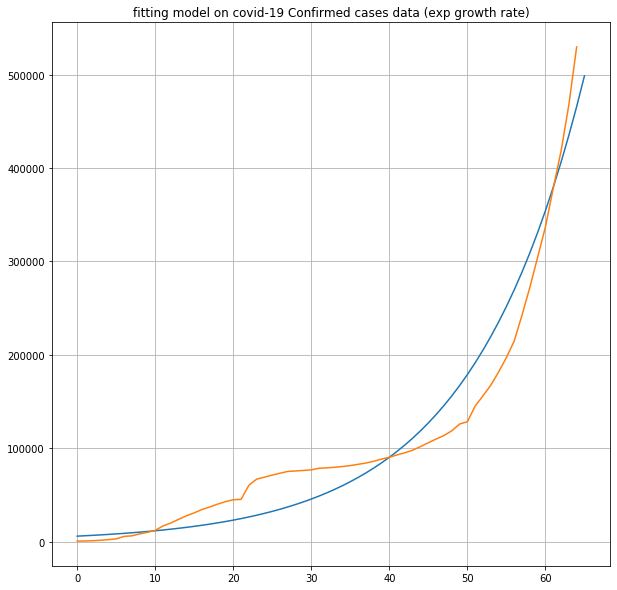

In [814]:
preds = []


for i in range(0,66):
    
    p = exp_growth(i)
    preds.append(p)
    

figure(figsize=(10,10))

title('fitting model on covid-19 Confirmed cases data (exp growth rate)')
grid()
plot(preds)
plot(targets)

In [662]:
# torch.exp((y * tstd) + tmean)

# 1 week Forcast (Day >> number of cases) 

array([529591.])

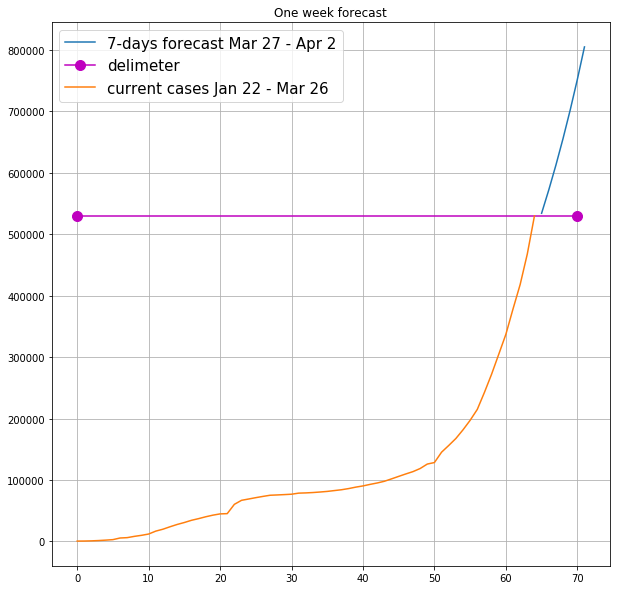

[(1, array([533908.94], dtype=float32)),
 (2, array([571679.6], dtype=float32)),
 (3, array([612122.4], dtype=float32)),
 (4, array([655426.1], dtype=float32)),
 (5, array([701793.4], dtype=float32)),
 (6, array([751440.8], dtype=float32)),
 (7, array([804600.56], dtype=float32))]

In [838]:
preds = []


for i in range(0, 65+8):
    
    if i < 66:
        preds.append(0)
        continue
    p = exp_growth(i)
    preds.append(p)
    

figure(figsize=(10,10))

title('One week forecast')
grid()
plot(np.arange(65, 65+7), preds[66:])

plot([0, 70], [targets[64][0], targets[64][0]], 'mo-', ms=10)

plot(targets)

legend(['7-days forecast Mar 27 - Apr 2', 'delimeter', 'current cases Jan 22 - Mar 26'], fontsize=15)

show()


list(zip((np.arange(len(preds[66:]) )+1), preds[66:] ))